## Detect fake profiles in online social networks using Random Forest anc DNN

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
#from sklearn.preprocessing import Imputer
import gender_guesser.detector as gender
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline 

###### function for reading dataset from csv files

In [15]:
def read_datasets():
    """ Reads users profile from csv files """
    genuine_users = pd.read_csv("data/users.csv")
    fake_users = pd.read_csv("data/fusers.csv")
    # print genuine_users.columns
    # print genuine_users.describe()
    #print fake_users.describe()
    x=pd.concat([genuine_users,fake_users])   
    y=len(fake_users)*[0] + len(genuine_users)*[1]
    return x,y
    

In [16]:

genuine_users = pd.read_csv("data/users.csv")
genuine_users.head()

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,created_at,url,...,profile_sidebar_fill_color,profile_background_image_url,profile_background_color,profile_link_color,utc_offset,protected,verified,description,updated,dataset
0,3610511,Davide Dellacasa,braddd,20370,5470,2385,145,52,Fri Apr 06 10:58:22 +0000 2007,http://braddd.tumblr.com,...,FFF7CC,http://a0.twimg.com/profile_background_images/...,BADFCD,FF0000,3600.0,NaN,NaN,Founder of http://www.screenweek.it & http://w...,2/14/2015 10:54,E13
1,5656162,Simone Economo,eKoeS,3131,506,381,9,40,Mon Apr 30 15:08:42 +0000 2007,http://www.lineheight.net/,...,DDEEF6,http://a0.twimg.com/images/themes/theme1/bg.png,C0DEED,0084B4,3600.0,NaN,NaN,BSc degree (cum laude) in Computer Engineering...,2/14/2015 10:54,E13
2,5682702,tacone,tacone_,4024,264,87,323,16,Tue May 01 11:53:40 +0000 2007,http://t.co/LKrl1dZE,...,0,http://a0.twimg.com/profile_background_images/...,1A1B1F,2FC2EF,3600.0,NaN,NaN,Cogito ergo bestemmio.,2/14/2015 10:54,E13
3,6067292,alesaura,alesstar,40586,640,622,1118,32,Tue May 15 16:55:16 +0000 2007,http://alesstar.wordpress.com/,...,95E8EC,http://a0.twimg.com/images/themes/theme4/bg.gif,0099B9,0099B9,3600.0,NaN,NaN,"Se la vita ti dà sarde, scapocciale!",2/14/2015 10:54,E13
4,6015122,Angelo,PerDiletto,2016,62,64,13,0,Sun May 13 19:52:00 +0000 2007,http://www.flickr.com/per_diletto,...,F6F6F6,http://a0.twimg.com/images/themes/theme18/bg.gif,ACDED6,38543,3600.0,NaN,NaN,Je me souviens,2/14/2015 10:54,E13


###### function for predicting sex using name of person

In [17]:
def predict_sex(name):
    name=str(name)
    sex_predictor = gender.Detector( case_sensitive=False)
    first_name= name.split(' ')[0]
    sex= sex_predictor.get_gender(first_name)
    sex_dict={'female': -2, 'mostly_female': -1,'unknown':0,'mostly_male':1, 'male': 2}
    sex_code = sex_dict[sex]
    return sex_code

###### function for feature engineering

In [18]:
def extract_features(x):
    lang_list = list(enumerate(np.unique(x['lang'])))   
    lang_dict = { name : i for i, name in lang_list }             
    x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)    
    x.loc[:,'sex_code']=predict_sex(x['name'])
    feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','sex_code','lang_code']
    x=x.loc[:,feature_columns_to_use]
    return x

In [19]:
print ("reading datasets.....\n")
x,y=read_datasets()

reading datasets.....



In [20]:
print ("extracting featues.....\n")
x=extract_features(x)
print (x.columns)
print (x.describe())

extracting featues.....

Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'sex_code', 'lang_code'],
      dtype='object')
       statuses_count  followers_count  friends_count  favourites_count  \
count     2818.000000      2818.000000    2818.000000       2818.000000   
mean      1672.198368       371.105039     395.363023        234.541164   
std       4884.669157      8022.631339     465.694322       1445.847248   
min          0.000000         0.000000       0.000000          0.000000   
25%         35.000000        17.000000     168.000000          0.000000   
50%         77.000000        26.000000     306.000000          0.000000   
75%       1087.750000       111.000000     519.000000         37.000000   
max      79876.000000    408372.000000   12773.000000      44349.000000   

       listed_count  sex_code    lang_code  
count   2818.000000    2818.0  2818.000000  
mean       2.818666       0.0     2.851313  
std       23

In [21]:
print ("spliting datasets in train and test dataset...\n")
X_train,X_test,y_train,y_test = train_test_split(x, y, test_size=0.20, random_state=44)

spliting datasets in train and test dataset...



# Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [23]:
random_forest = RandomForestClassifier(n_estimators=100)

In [24]:
random_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [25]:
y_pred = random_forest.predict(X_test)

In [26]:
acc1=accuracy_score(y_pred,y_test)
acc1

0.9450354609929078

In [27]:
cnf_matrix = confusion_matrix(y_test,y_pred)

In [28]:
print(cnf_matrix)

[[267   1]
 [ 30 266]]


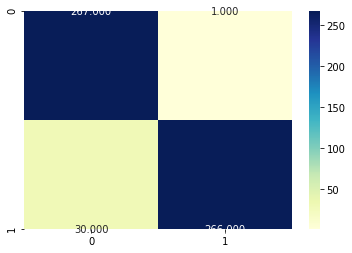

In [32]:
import seaborn as sns
labels = [0,1]
sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)

In [17]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9491478418717225

Text(0.5, 0, 'False Positive Rate')

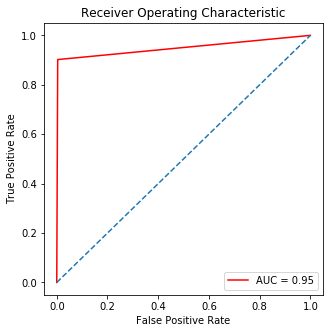

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# LogisticRegression

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
log=LogisticRegression()

In [21]:
log.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
y_pred = log.predict(X_test)

In [23]:
acc2=accuracy_score(y_pred,y_test)
acc2

0.9024822695035462

In [24]:
cnf_matrix = confusion_matrix(y_test,y_pred)

In [25]:
print(cnf_matrix)

[[240  28]
 [ 27 269]]


<Figure size 1440x1008 with 0 Axes>

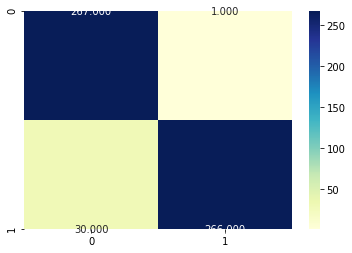

<Figure size 1440x1008 with 0 Axes>

In [39]:
import seaborn as sns
labels = [0,1]
sns.heatmap(cnf_matrix, annot=True,annot_kws={"size": 10}, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.figure(figsize = (20,14))

<Figure size 432x288 with 0 Axes>

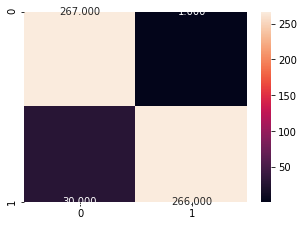

<Figure size 432x288 with 0 Axes>

In [48]:
import seaborn as sns
labels = [0,1]
plt.figure(figsize = (5,3.5))
sns.heatmap(cnf_matrix, annot=True,annot_kws={"size": 10},fmt=".3f", xticklabels=labels, yticklabels=labels)


In [27]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9021530859217427

Text(0.5, 0, 'False Positive Rate')

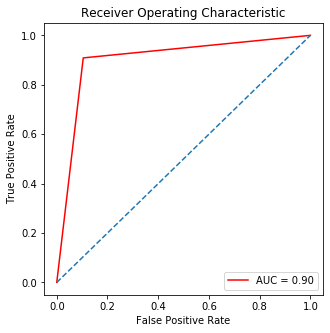

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# SVM

In [29]:
from sklearn import svm

In [30]:
support = svm.LinearSVC(random_state=20)

In [31]:
support.fit(X_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=20, tol=0.0001,
          verbose=0)

In [32]:
y_pred = support.predict(X_test)

In [33]:
acc3=metrics.accuracy_score(y_test,y_pred)
print(acc3)

0.9361702127659575


In [34]:
cnf_matrix = confusion_matrix(y_test,y_pred)

In [35]:
print(cnf_matrix)

[[261   7]
 [ 29 267]]


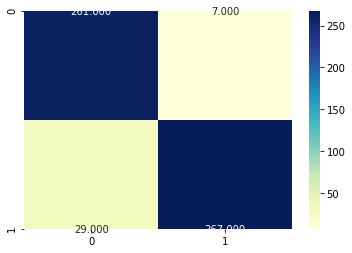

In [36]:
import seaborn as sns
labels = [0,1]
sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)

In [37]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9379538120209762

Text(0.5, 0, 'False Positive Rate')

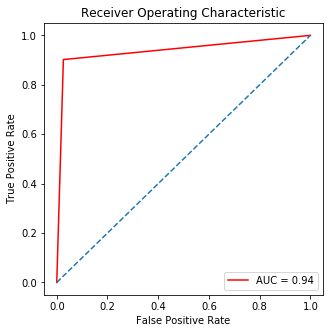

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')